In [28]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import random as rnd

from scipy.sparse import *

from matplotlib import pyplot

In [29]:
urm_path = '../content/data_train.csv'
urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [30]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [31]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [32]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


# Remove empty profiles

In [33]:
# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)



# Let's create the mapping from items indices to original item_ids
item_index_to_original_ID = pd.Series(item_original_ID_to_index.index,index = item_original_ID_to_index.values)



original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

New index for item 125 is 93


,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [34]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


In [35]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [36]:
urm_all = urm_all.tocsr()
urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [ ]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

### Fix and save data folds of train_recommender, train_xgboost

In [ ]:
train_split = 0.80

data_folds = []

for k in range(5):
  urm_train_fold = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/train_noemptyprofiles_fold{k}.npz')

  urm_train_fold = sps.coo_matrix(urm_train_fold)

  n_interactions = urm_train_fold.nnz

  train_recommender_mask = np.random.choice([True,False], n_interactions, p=[train_split, 1-train_split])

  urm_train_recommender = sps.csr_matrix((urm_train_fold.data[train_recommender_mask],
                            (urm_train_fold.row[train_recommender_mask], urm_train_fold.col[train_recommender_mask])))

  train_xgboost_mask = np.logical_not(train_recommender_mask)

  urm_train_xgboost = sps.csr_matrix((urm_train_fold.data[train_xgboost_mask],
                            (urm_train_fold.row[train_xgboost_mask], urm_train_fold.col[train_xgboost_mask])))

  data_folds.append({"recommender":urm_train_recommender, 'xgboost':urm_train_xgboost})


In [ ]:
data_folds[0]['xgboost']

<12638x22218 sparse matrix of type '<class 'numpy.float64'>'
	with 76760 stored elements in Compressed Sparse Row format>

In [ ]:

from scipy.sparse import save_npz, load_npz


for k,fold in enumerate(data_folds):
      print(f'Fold {k} recommender train saving')
      save_npz(f"/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/recommender_train_noemptyprofiles_fold{k}.npz", fold['recommender'])
      print(f'Fold {k} xgboost train saving')
      save_npz(f"/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/xgboost_train_noemptyprofiles_fold{k}.npz", fold['xgboost'])

Fold 0 recommender train saving
Fold 0 xgboost train saving
Fold 1 recommender train saving
Fold 1 xgboost train saving
Fold 2 recommender train saving
Fold 2 xgboost train saving
Fold 3 recommender train saving
Fold 3 xgboost train saving
Fold 4 recommender train saving
Fold 4 xgboost train saving


**Check if the saved folds are the same after loading**

In [ ]:
for k,fold in enumerate(data_folds):
      print(f'Fold {k}')
      print(np.array_equal(load_npz(f"/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/recommender_train_noemptyprofiles_fold{k}.npz").indices,data_folds[k]['recommender'].indices))
      print(np.array_equal(load_npz(f"/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/xgboost_train_noemptyprofiles_fold{k}.npz").indices,data_folds[k]['xgboost'].indices))



Fold 0
True
True
Fold 1
True
True
Fold 2
True
True
Fold 3
True
True
Fold 4
True
True


# K-fold Cross-Validatoin


### Load the similarity matrices of models trained on different train folds

In [2]:
from scipy.sparse import save_npz, load_npz

In [3]:
data_folds = []

for fold_n in range(5):
  fold_urm_train = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/train_noemptyprofiles_fold{fold_n}.npz')
  fold_urm_val = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/val_noemptyprofiles_fold{fold_n}.npz')
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})

print(data_folds)

[{'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22217 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train': <12638x22221 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22218 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22220 sparse matrix of type '<class 'numpy.float64'>'
	w

In [4]:
# SLIM elasticnet

S_slim_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold0_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold1_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold2_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold3_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold4_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

In [5]:
S_slim_fold0.indices.shape

(2240133,)

In [6]:
S_slim_fold0.data.shape

(2240133,)

In [7]:
# IBCF

S_ibcf_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold0_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold1_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold2_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold3_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold4_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

In [8]:
S_ibcf_fold0.indices.shape

(308988,)

In [9]:
S_ibcf_fold0.data.shape

(308988,)

In [10]:
# RP3Beta

S_rp3beta_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold0_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold1_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold2_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold3_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold4_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

In [11]:
S_rp3beta_fold0.indices.shape

(3527025,)

In [12]:
S_rp3beta_fold0.data.shape

(3527025,)

In [13]:
# EASER

S_easer_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold0_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold1_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold2_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold3_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold4_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

In [14]:
S_easer_fold0.indices.shape

(5016019,)

In [15]:
S_easer_fold0.data.shape

(5016019,)

In [16]:
S_models_fold0 = {
    "SLIM":S_slim_fold0, "IBCF":S_ibcf_fold0,"rp3beta":S_rp3beta_fold0,"EASER":S_easer_fold0
}

S_models_fold1 = {
    "SLIM":S_slim_fold1, "IBCF":S_ibcf_fold1,"rp3beta":S_rp3beta_fold1,"EASER":S_easer_fold1
}

S_models_fold2 = {
    "SLIM":S_slim_fold2, "IBCF":S_ibcf_fold2,"rp3beta":S_rp3beta_fold2,"EASER":S_easer_fold2
}

S_models_fold3 = {
    "SLIM":S_slim_fold3, "IBCF":S_ibcf_fold3,"rp3beta":S_rp3beta_fold3,"EASER":S_easer_fold3
}

S_models_fold4 = {
    "SLIM":S_slim_fold4, "IBCF":S_ibcf_fold4,"rp3beta":S_rp3beta_fold4,"EASER":S_easer_fold4
}

fold_models = [S_models_fold0,S_models_fold1,S_models_fold2,S_models_fold3,S_models_fold4]

### Load the data and similarity matrices of models trained on different RECOMMENDER Train XGboost subfolds

In [17]:
data_xgboostfolds = []

for fold_n in range(5):
  fold_urm_train_recommender = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/Folds/recommender_train_noemptyprofiles_fold{fold_n}.npz')
  fold_urm_train_xgboost = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/Folds/xgboost_train_noemptyprofiles_fold{fold_n}.npz')
  fold_urm_val = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/Folds/val_noemptyprofiles_fold{fold_n}.npz')
  data_xgboostfolds.append({"train_recommender":fold_urm_train_recommender,"train_xgboost":fold_urm_train_xgboost,"val":fold_urm_val})

print(data_xgboostfolds)

[{'train_recommender': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 306224 stored elements in Compressed Sparse Row format>, 'train_xgboost': <12638x22218 sparse matrix of type '<class 'numpy.float64'>'
	with 76760 stored elements in Compressed Sparse Row format>, 'val': <12638x22217 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train_recommender': <12638x22221 sparse matrix of type '<class 'numpy.float64'>'
	with 306642 stored elements in Compressed Sparse Row format>, 'train_xgboost': <12638x22218 sparse matrix of type '<class 'numpy.float64'>'
	with 76342 stored elements in Compressed Sparse Row format>, 'val': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train_recommender': <12638x22221 sparse matrix of type '<class 'numpy.float64'>'
	with 306156 stored elements in Compressed Sparse Row format>, 'train_xgboost': <1

In [18]:
# SLIM elasticnet

S_slim_xgboostfold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/SLIMelasticnet/ItItSimilarity_trained_RecommenderFold0_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_xgboostfold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/SLIMelasticnet/ItItSimilarity_trained_RecommenderFold1_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_xgboostfold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/SLIMelasticnet/ItItSimilarity_trained_RecommenderFold2_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_xgboostfold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/SLIMelasticnet/ItItSimilarity_trained_RecommenderFold3_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_xgboostfold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/SLIMelasticnet/ItItSimilarity_trained_RecommenderFold4_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

In [19]:
# IBCF

S_ibcf_xgboostfold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/IBCF/ItItSimilarity_trained_RecommenderFold0_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_xgboostfold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/IBCF/ItItSimilarity_trained_RecommenderFold1_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_xgboostfold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/IBCF/ItItSimilarity_trained_RecommenderFold2_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_xgboostfold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/IBCF/ItItSimilarity_trained_RecommenderFold3_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_xgboostfold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/IBCF/ItItSimilarity_trained_RecommenderFold4_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

In [20]:
# RP3Beta

S_rp3beta_xgboostfold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/RP3Beta/ItItSimilarity_trained_RecommenderFold0_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_xgboostfold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/RP3Beta/ItItSimilarity_trained_RecommenderFold1_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_xgboostfold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/RP3Beta/ItItSimilarity_trained_RecommenderFold2_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_xgboostfold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/RP3Beta/ItItSimilarity_trained_RecommenderFold3_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_xgboostfold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/RP3Beta/ItItSimilarity_trained_RecommenderFold4_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

In [21]:
# EASER

S_easer_xgboostfold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/EASER/ItItSimilarity_trained_RecommenderFold0_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_xgboostfold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/EASER/ItItSimilarity_trained_RecommenderFold1_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_xgboostfold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/EASER/ItItSimilarity_trained_RecommenderFold2_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_xgboostfold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/EASER/ItItSimilarity_trained_RecommenderFold3_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_xgboostfold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /XGboost_folds/EASER/ItItSimilarity_trained_RecommenderFold4_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

In [22]:
S_models_xgboostfold0 = {
    "SLIM":S_slim_xgboostfold0, "IBCF":S_ibcf_xgboostfold0,"rp3beta":S_rp3beta_xgboostfold0,"EASER":S_easer_xgboostfold0
}

S_models_xgboostfold1 = {
    "SLIM":S_slim_xgboostfold1, "IBCF":S_ibcf_xgboostfold1,"rp3beta":S_rp3beta_xgboostfold1,"EASER":S_easer_xgboostfold1
}

S_models_xgboostfold2 = {
    "SLIM":S_slim_xgboostfold2, "IBCF":S_ibcf_xgboostfold2,"rp3beta":S_rp3beta_xgboostfold2,"EASER":S_easer_xgboostfold2
}

S_models_xgboostfold3 = {
    "SLIM":S_slim_xgboostfold3, "IBCF":S_ibcf_xgboostfold3,"rp3beta":S_rp3beta_xgboostfold3,"EASER":S_easer_xgboostfold3
}

S_models_xgboostfold4 = {
    "SLIM":S_slim_xgboostfold4, "IBCF":S_ibcf_xgboostfold4,"rp3beta":S_rp3beta_xgboostfold4,"EASER":S_easer_xgboostfold4
}

xgboostfold_models = [S_models_xgboostfold0,S_models_xgboostfold1,S_models_xgboostfold2,S_models_xgboostfold3,S_models_xgboostfold4]

### Utils for hybrid evaluation

In [23]:
!unzip /content/Recommenders.zip
!unzip /content/Utils.zip

Archive:  /content/Recommenders.zip
  inflating: Recommenders/BaseCBFRecommender.py  
  inflating: Recommenders/BaseMatrixFactorizationRecommender.py  
  inflating: Recommenders/BaseRecommender.py  
  inflating: Recommenders/BaseSimilarityMatrixRecommender.py  
  inflating: Recommenders/BaseTempFolder.py  
  inflating: Recommenders/DataIO.py  
   creating: Recommenders/EASE_R/
  inflating: Recommenders/EASE_R/EASE_R_Recommender.py  
   creating: Recommenders/FactorizationMachines/
  inflating: Recommenders/FactorizationMachines/LightFMRecommender.py  
   creating: Recommenders/FeatureWeighting/
  inflating: Recommenders/FeatureWeighting/CFW_D_Similarity_Linalg.py  
   creating: Recommenders/FeatureWeighting/Cython/
  inflating: Recommenders/FeatureWeighting/Cython/CFW_D_Similarity_Cython.py  
  inflating: Recommenders/FeatureWeighting/Cython/CFW_D_Similarity_Cython_SGD.cp38-win_amd64.pyd  
  inflating: Recommenders/FeatureWeighting/Cython/CFW_D_Similarity_Cython_SGD.cpython-38-x86_64-l

In [24]:
import gc

In [25]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

In [26]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at,exclude_seen=True)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.10f}, Recall = {:.10f}, MAP = {:.10f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

In [27]:
class Predictor(object):

    def __init__(self, URM, model):
        self.URM = URM
        self.model = model

    def recommend(self, user_id, at=10, exclude_seen=True):
        # Check if user_id is a valid index
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return

        # compute the scores using the fitted model
        scores = self.model._compute_item_score(user_id)[0]

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Train XGboost model

**Define our best model i.e. NON-NORMALISED SIMILARITIES hybrid 0.685907*(0.88*SLIM elasticnet + 0.12*IBCF) + (1 - 0.685907)EASER**

In [ ]:
# Define our best submission model i.e. hybrid of NON-NORMALISED SIMILARITIES 0.685907*(0.88*SLIM elasticnet + 0.12*IBCF)+(1 - 0.685907)*EASER

alpha = 0.88
beta = 0.685907

data_fold0 = data_folds[0]

S_slim_elastic_f0 = S_models_fold0["SLIM"]
S_ibcf_f0 = S_models_fold0["IBCF"]
S_easer_f0 = S_models_fold0["EASER"]
hybrid_similarity = beta * ((1 - alpha) * S_ibcf_f0  + alpha * S_slim_elastic_f0) + (1 - beta) * S_easer_f0

hybrid_recommender_object = ItemKNNCustomSimilarityRecommender(data_fold0['train'])
hybrid_recommender_object.fit(hybrid_similarity)
hybrid_3models = Predictor(URM=data_fold0['train'], model = hybrid_recommender_object)



ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


**Build the dataframe with the predictions**

In [ ]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = data_fold0['train'].shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [ ]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
12633,NaN
12634,NaN
12635,NaN


In [ ]:
cutoff = 151

for user_id in tqdm(range(n_users)):
    recommendations = hybrid_3models.recommend(user_id, at = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations



100%|██████████| 12638/12638 [00:31<00:00, 398.98it/s]


In [ ]:
training_dataframe

,ItemID
UserID,
0,"[587, 674, 1449, 4, 1167, 2755, 1089, 3186, 24..."
1,"[2548, 89, 227, 84, 1831, 812, 887, 83, 3119, ..."
2,"[7347, 5375, 8126, 8303, 189, 4809, 3612, 1073..."
3,"[589, 49, 83, 227, 812, 841, 815, 1425, 5279, ..."
4,"[323, 950, 559, 4316, 1239, 4709, 954, 955, 95..."
...,...
12633,"[2809, 2818, 2807, 2815, 2817, 2811, 4, 22, 30..."
12634,"[2810, 3958, 3943, 3328, 3950, 3955, 3949, 114..."
12635,"[257, 248, 474, 259, 472, 470, 4864, 15770, 83..."


**Let's transform the dataframe so that we have one recommendation per row**

In [ ]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe['ItemID'] = pd.to_numeric(training_dataframe['ItemID'])
training_dataframe

,ItemID
UserID,
0,587
0,674
0,1449
0,4
0,1167
...,...
12637,1738
12637,14618
12637,6160


**We should add the target column, which is the correct recommendation as contained in the validation data**

In [ ]:
URM_validation_coo = sps.coo_matrix(data_fold0['val'])

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,3
1,0,4
2,0,7
3,0,16
4,0,17
...,...,...
95741,12637,11426
95742,12637,13248
95743,12637,16585
95744,12637,16594


In [ ]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,587,left_only
1,0,674,left_only
2,0,1449,left_only
3,0,4,both
4,0,1167,left_only
...,...,...,...
1908333,12637,1738,left_only
1908334,12637,14618,left_only
1908335,12637,6160,left_only
1908336,12637,6484,left_only


In [ ]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,587,False
1,0,674,False
2,0,1449,False
3,0,4,True
4,0,1167,False
...,...,...,...
1908333,12637,1738,False
1908334,12637,14618,False
1908335,12637,6160,False
1908336,12637,6484,False


<Axes: >

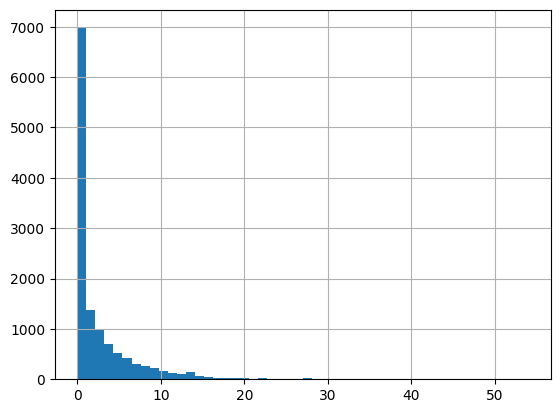

In [ ]:
training_dataframe.groupby(["UserID"])["Label"].sum().hist(bins = 50, xlabelsize = 10)

**Now let's add features as the prediction of other algorithms**

In [ ]:
S_rp3beta_elastic_f0 = S_models_fold0["rp3beta"]
rp3beta_recommender_object = ItemKNNCustomSimilarityRecommender(data_fold0['train'])
rp3beta_recommender_object.fit(S_rp3beta_elastic_f0)

S_ibcf_f0 = S_models_fold0["IBCF"]
ibcf_recommender_object = ItemKNNCustomSimilarityRecommender(data_fold0['train'])
ibcf_recommender_object.fit(S_ibcf_f0)

S_easer_f0 = S_models_fold0["EASER"]
easer_recommender_object = ItemKNNCustomSimilarityRecommender(data_fold0['train'])
easer_recommender_object.fit(S_easer_f0)



other_algorithms = {
    "rp3beta": rp3beta_recommender_object,
    "EASER": easer_recommender_object,
    "IBCF":ibcf_recommender_object
}


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


In [ ]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 12638/12638 [01:18<00:00, 160.39it/s]


,UserID,ItemID,Label,rp3beta,EASER,IBCF
0,0,587,False,1.756946,0.384206,0.885922
1,0,674,False,1.890487,0.325518,0.612876
2,0,1449,False,1.065335,0.203652,0.650260
3,0,4,True,1.535873,0.230577,0.489168
4,0,1167,False,1.207187,0.243150,0.380579
...,...,...,...,...,...,...
1908333,12637,1738,False,0.357756,0.080235,0.000000
1908334,12637,14618,False,0.564915,0.034945,0.162714
1908335,12637,6160,False,0.442453,0.062528,0.000000
1908336,12637,6484,False,0.212889,0.038580,0.222617


**Latent features of PureSVD**

In [ ]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
pureSVDRecommender = PureSVDRecommender(data_fold0['train'])
pureSVDRecommender.fit(num_factors=10)
itemFactors = pureSVDRecommender.ITEM_factors
userFactors = pureSVDRecommender.USER_factors

from sklearn.preprocessing import normalize
normed_itemFactors = normalize(itemFactors, axis=1, norm='l1')
normed_userFactors = normalize(userFactors, axis=1, norm='l1')

print(normed_itemFactors.shape)
print(normed_userFactors.shape)

PureSVDRecommender: URM Detected 205 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.66 sec
(22222, 10)
(12638, 10)


In [ ]:
normed_itemFactors_df = pd.DataFrame(normed_itemFactors, columns = ["itemFactor0",'itemFactor1','itemFactor2','itemFactor3','itemFactor4',
                                                                    'itemFactor5','itemFactor6','itemFactor7','itemFactor8','itemFactor9'])
normed_itemFactors_df

,itemFactor0,itemFactor1,itemFactor2,itemFactor3,itemFactor4,itemFactor5,itemFactor6,itemFactor7,itemFactor8,itemFactor9
0,0.099039,-0.006951,-0.009004,-0.150812,-0.083683,0.013602,-0.104614,-0.277139,0.061397,0.193759
1,0.112978,0.036963,0.112078,-0.173679,0.021896,-0.054832,-0.072058,-0.002248,0.257467,0.155803
2,0.185113,0.103574,-0.036629,-0.050631,-0.116264,-0.255603,-0.053186,0.022738,-0.106124,0.070138
3,0.077702,-0.033559,0.142827,0.152191,0.186097,-0.103973,-0.104470,0.050221,-0.123980,0.024979
4,0.116260,0.000711,0.126597,-0.159332,0.041421,-0.089816,-0.018870,0.055816,0.243745,0.147432
...,...,...,...,...,...,...,...,...,...,...
22217,0.101302,0.152961,-0.038380,-0.048141,0.008369,0.076266,0.175781,-0.179045,0.196367,-0.023388
22218,0.046362,0.080994,0.167307,-0.160797,-0.000730,-0.108668,-0.091211,0.090505,-0.024772,-0.228654
22219,0.070698,-0.102807,0.134520,-0.012995,-0.048007,0.175354,0.035686,0.009395,0.335489,0.075049
22220,0.055077,-0.150668,-0.039995,0.113479,-0.081226,-0.177495,-0.086414,-0.190002,-0.036653,-0.068990


In [ ]:
training_dataframe = training_dataframe.set_index('ItemID').join(normed_itemFactors_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

,ItemID,UserID,Label,rp3beta,EASER,IBCF,itemFactor0,itemFactor1,itemFactor2,itemFactor3,itemFactor4,itemFactor5,itemFactor6,itemFactor7,itemFactor8,itemFactor9
0,0,3,False,2.047621,0.128153,0.288104,0.099039,-0.006951,-0.009004,-0.150812,-0.083683,0.013602,-0.104614,-0.277139,0.061397,0.193759
1,0,5,False,1.698007,0.114057,0.318720,0.099039,-0.006951,-0.009004,-0.150812,-0.083683,0.013602,-0.104614,-0.277139,0.061397,0.193759
2,0,7,False,0.712164,0.042095,0.153959,0.099039,-0.006951,-0.009004,-0.150812,-0.083683,0.013602,-0.104614,-0.277139,0.061397,0.193759
3,0,9,False,1.858549,0.241521,0.144286,0.099039,-0.006951,-0.009004,-0.150812,-0.083683,0.013602,-0.104614,-0.277139,0.061397,0.193759
4,0,10,False,2.853014,0.092005,0.451400,0.099039,-0.006951,-0.009004,-0.150812,-0.083683,0.013602,-0.104614,-0.277139,0.061397,0.193759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908333,22221,12390,False,0.000000,0.000000,0.000000,0.033695,0.044788,0.167478,0.171664,0.132368,-0.171451,0.017306,0.108904,-0.129024,-0.023322
1908334,22221,12399,False,0.000000,0.000000,0.000000,0.033695,0.044788,0.167478,0.171664,0.132368,-0.171451,0.017306,0.108904,-0.129024,-0.023322
1908335,22221,12453,False,0.000000,0.000000,0.000000,0.033695,0.044788,0.167478,0.171664,0.132368,-0.171451,0.017306,0.108904,-0.129024,-0.023322
1908336,22221,12496,False,0.000000,0.000000,0.000000,0.033695,0.044788,0.167478,0.171664,0.132368,-0.171451,0.017306,0.108904,-0.129024,-0.023322


In [ ]:
normed_userFactors_df = pd.DataFrame(normed_userFactors, columns = ["userFactor0",'userFactor1','userFactor2','userFactor3','userFactor4',
                                                                    'userFactor5','userFactor6','userFactor7','userFactor8','userFactor9'])
normed_userFactors_df

,userFactor0,userFactor1,userFactor2,userFactor3,userFactor4,userFactor5,userFactor6,userFactor7,userFactor8,userFactor9
0,0.081978,0.007056,0.099406,-0.158142,-0.010210,-0.038410,-0.085796,-0.155521,0.154399,0.209081
1,0.129263,-0.051278,-0.160349,-0.231765,-0.005716,-0.158726,-0.081476,0.035250,0.006166,0.140012
2,0.078612,-0.164834,-0.065405,-0.202867,0.045865,0.031887,0.131343,-0.144884,-0.099595,0.034709
3,0.108909,-0.111623,-0.120724,-0.157616,0.082569,-0.078864,0.058888,0.218554,-0.006173,-0.056079
4,0.152478,0.246516,0.070803,0.019838,0.013144,0.001506,0.202026,0.012226,-0.165778,-0.115685
...,...,...,...,...,...,...,...,...,...,...
12633,0.064873,0.038296,0.149855,-0.198048,0.093622,0.011527,-0.046745,0.020502,0.231693,0.144840
12634,0.081336,0.050425,0.177426,0.175935,0.127276,-0.152360,0.015407,0.092188,-0.109054,-0.018595
12635,0.068369,-0.023047,0.181500,0.115460,-0.050873,-0.097932,0.104107,0.155534,0.094855,-0.108323
12636,0.093903,-0.162335,0.001730,-0.027634,-0.007825,-0.307850,0.228581,-0.073397,0.067952,0.028794


In [ ]:
training_dataframe = training_dataframe.set_index('UserID').join(normed_userFactors_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

,UserID,ItemID,Label,rp3beta,EASER,IBCF,itemFactor0,itemFactor1,itemFactor2,itemFactor3,...,userFactor0,userFactor1,userFactor2,userFactor3,userFactor4,userFactor5,userFactor6,userFactor7,userFactor8,userFactor9
0,0,4,True,1.535873,0.230577,0.489168,0.116260,0.000711,0.126597,-0.159332,...,0.081978,0.007056,0.099406,-0.158142,-0.010210,-0.038410,-0.085796,-0.155521,0.154399,0.209081
1,0,16,True,0.794009,0.098931,0.556340,0.126873,0.000793,0.146244,-0.193258,...,0.081978,0.007056,0.099406,-0.158142,-0.010210,-0.038410,-0.085796,-0.155521,0.154399,0.209081
2,0,17,True,0.164061,0.046979,0.188684,0.130768,-0.019988,0.080711,-0.052103,...,0.081978,0.007056,0.099406,-0.158142,-0.010210,-0.038410,-0.085796,-0.155521,0.154399,0.209081
3,0,24,True,0.638823,0.111935,0.423274,0.111710,0.064457,0.107305,-0.141957,...,0.081978,0.007056,0.099406,-0.158142,-0.010210,-0.038410,-0.085796,-0.155521,0.154399,0.209081
4,0,44,False,1.022867,0.100595,0.000000,0.123355,0.033232,-0.127137,0.002945,...,0.081978,0.007056,0.099406,-0.158142,-0.010210,-0.038410,-0.085796,-0.155521,0.154399,0.209081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908333,12637,17580,False,2.024389,0.120900,1.210571,0.045269,-0.103171,0.099685,0.099329,...,0.091877,-0.087480,0.016557,0.045475,0.179444,0.001815,-0.156926,-0.129954,0.076893,0.213580
1908334,12637,17581,True,2.187028,0.160564,1.387581,0.048981,-0.149747,0.102644,0.094686,...,0.091877,-0.087480,0.016557,0.045475,0.179444,0.001815,-0.156926,-0.129954,0.076893,0.213580
1908335,12637,19251,False,0.990522,0.049775,0.486385,0.029014,-0.156573,0.145388,0.086262,...,0.091877,-0.087480,0.016557,0.045475,0.179444,0.001815,-0.156926,-0.129954,0.076893,0.213580
1908336,12637,19713,False,1.102953,0.098889,0.379392,0.045032,-0.146604,0.121383,0.082879,...,0.091877,-0.087480,0.016557,0.045475,0.179444,0.001815,-0.156926,-0.129954,0.076893,0.213580


**The popularity of the item, the user activity and etc. features**

In [ ]:
item_popularity = np.ediff1d(sps.csc_matrix(data_fold0['train']).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,rp3beta,EASER,IBCF,item_popularity
0,0,587,False,1.756946,0.384206,0.885922,586
1,0,674,False,1.890487,0.325518,0.612876,342
2,0,1449,False,1.065335,0.203652,0.650260,97
3,0,4,True,1.535873,0.230577,0.489168,208
4,0,1167,False,1.207187,0.243150,0.380579,274
...,...,...,...,...,...,...,...
379135,12637,1487,True,1.885228,0.125901,0.877917,64
379136,12637,821,False,1.422612,0.190398,0.547981,147
379137,12637,371,False,1.501966,0.162347,0.767767,36
379138,12637,13255,False,1.306112,0.090506,1.258470,6


**The profile length**

In [ ]:
user_popularity = np.ediff1d(sps.csr_matrix(data_fold0['train']).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,rp3beta,EASER,IBCF,item_popularity,user_profile_len
0,0,587,False,1.756946,0.384206,0.885922,586,36
1,0,674,False,1.890487,0.325518,0.612876,342,36
2,0,1449,False,1.065335,0.203652,0.650260,97,36
3,0,4,True,1.535873,0.230577,0.489168,208,36
4,0,1167,False,1.207187,0.243150,0.380579,274,36
...,...,...,...,...,...,...,...,...
379135,12637,1487,True,1.885228,0.125901,0.877917,64,52
379136,12637,821,False,1.422612,0.190398,0.547981,147,52
379137,12637,371,False,1.501966,0.162347,0.767767,36,52
379138,12637,13255,False,1.306112,0.090506,1.258470,6,52


**Then we train XGBoost to rerank those prediction using as lable whether they should be recommended or not**

In [ ]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,rp3beta,EASER,IBCF,item_popularity,user_profile_len
0,0,587,False,1.756946,0.384206,0.885922,586,36
1,0,2441,False,0.224008,0.081729,0.139770,148,36
2,0,353,False,0.323550,0.097789,0.307937,71,36
3,0,818,False,0.355252,0.075370,0.206294,227,36
4,0,4512,False,0.726684,0.076388,0.393346,56,36
...,...,...,...,...,...,...,...,...
379135,12637,9567,False,2.224067,0.254522,1.413900,37,52
379136,12637,10897,True,2.262047,0.280913,1.609995,37,52
379137,12637,13255,False,1.306112,0.090506,1.258470,6,52
379138,12637,17581,True,2.187028,0.160564,1.387581,16,52


**To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidate items for each user all groups have the same length.**

In [ ]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [ ]:
from xgboost import XGBRanker

In [ ]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [ ]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

**Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will ten need to rank as we do in any other recommender model.**

**Important: In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:**
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

In [ ]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.2565843 ,  0.27490893, -0.250986  , -0.24144211, -0.29718634,
       -0.31641072, -0.3245903 , -0.20923628, -0.35899344, -0.3245903 ,
       -0.28383622, -0.07109964, -0.37747353,  0.2520674 , -0.2932258 ,
        0.36810806,  1.0093828 ,  1.1819785 ,  1.1917181 ,  1.021272  ,
        0.8982047 ,  0.59375584,  0.12822105,  0.43776497,  0.20555688,
        0.5851283 ,  0.5809084 ,  0.18386793,  0.26542002,  1.2731144 ],
      dtype=float32)

**We can have a look to the feature importance to assess which are the most informative ones**

In [ ]:
%matplotlib inline
from xgboost import plot_importance

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

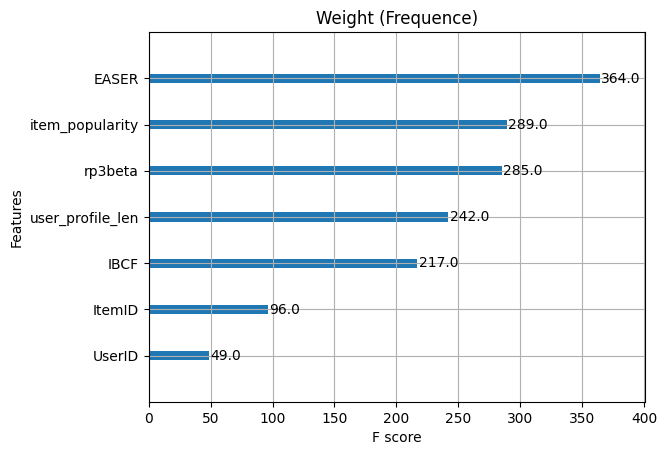

In [ ]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

**Note, here ItemID and UserID are provided as integers, meaning that XGBoost will use them as any integer number and may split user groups according to whether their ID is < or > of a certain value. This makes no sense of course because the IDs are not ordinal, they are categorical and the specific numerical value of an IDs has no relation with the semantics of the problem.**

How to address this?
- Use one-hot-encoded values -> drawback, the number of columns becomes very large
- Use the native "Categorical" data type -> drawback, it is still experimental and may not work very well
- Use another representation of the IDs, such as target encoding -> drawback, some further processing is needed and no teaching material is provided on this

In [ ]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [ ]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [ ]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.17239827, -0.06851576, -0.09614527, -0.09614527, -0.10423802,
       -0.16192067, -0.11378174, -0.09614527,  0.26744825, -0.2168153 ,
       -0.11270759, -0.03898488, -0.33882162, -0.03015451, -0.14790651,
        0.01517422,  0.26782247,  0.32521176,  0.42059007,  0.29999056,
        0.14317676,  0.17885445, -0.15159065,  0.01517422,  0.05314713,
        0.09608737,  0.16421627,  0.02612853,  0.0342335 ,  0.26353723],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

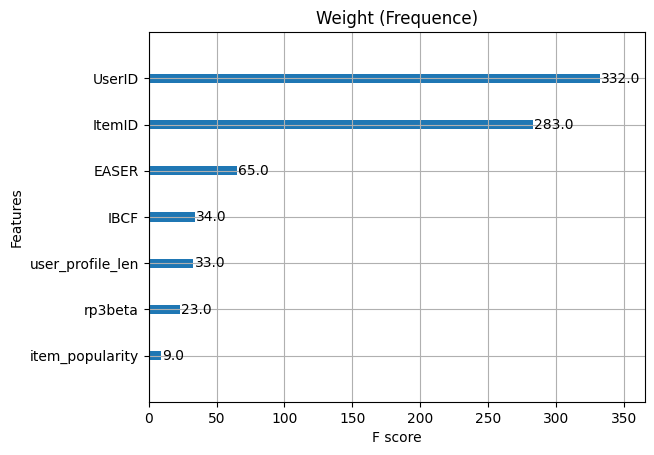

In [ ]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

## Evaluate the XGboost model

In [37]:
def evaluate_xgboost(URM_test,feature_dataframe, xgboost_model, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0

    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

          # Extract the predictions and features for the user
          X_to_predict = feature_dataframe[feature_dataframe["UserID"] == user_id]
          # Do the reranking prediction
          item_reranking_scores = xgboost_model.predict(X_to_predict)
          if len(item_reranking_scores) == 0:
            print(f'Lenght of reranking for user {usr_idx} is 0')
          # Rerank the items according to the reranking scores
          initial_recommendations = X_to_predict.ItemID.to_list()
          reranked_recommendations = np.array(initial_recommendations)[np.argsort(item_reranking_scores)[::-1]][:at]

          num_eval+=1

          cumulative_precision += precision(reranked_recommendations, relevant_items)
          cumulative_recall += recall(reranked_recommendations, relevant_items)
          cumulative_AP += AP(reranked_recommendations, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.10f}, Recall = {:.10f}, MAP = {:.10f}".format(
        cumulative_precision, cumulative_recall, MAP))

    return MAP, mean_precision, mean_recall

In [38]:
# Define the function for training XGboost model
from xgboost import XGBRanker
from tqdm import tqdm
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from sklearn.preprocessing import normalize


def prepare_training_df(urm_train_recommender,urm_train_xgboost,initial_recommender,initial_recommendations_cutoff,other_algorithms):
  # Build the dataframe with the predictions
  n_users, n_items = urm_train_recommender.shape
  training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
  training_dataframe.index.name='UserID'

  for user_id in tqdm(range(n_users)):
    recommendations = initial_recommender.recommend(user_id, at = initial_recommendations_cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

  # Let's transform the dataframe so that we have one recommendation per row
  training_dataframe = training_dataframe.explode("ItemID")
  training_dataframe['ItemID'] = pd.to_numeric(training_dataframe['ItemID'])

  # We should add the target column, which is the correct recommendation as contained in the validation data
  URM_train_xgboost_coo = sps.coo_matrix(urm_train_xgboost)
  correct_recommendations = pd.DataFrame({"UserID": URM_train_xgboost_coo.row,
                                        "ItemID": URM_train_xgboost_coo.col})

  training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
  training_dataframe["Label"] = training_dataframe["Exist"] == "both"
  training_dataframe.drop(columns = ['Exist'], inplace=True)

  # Now let's add features as the prediction of other algorithms

  training_dataframe = training_dataframe.set_index('UserID')

  for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():
      if rec_label in ['PureSVD_itemFactors','PureSVD_userFactors']:
        continue

      item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

      all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

      training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

  training_dataframe = training_dataframe.reset_index()
  training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})

  # The latent features from PureSVD model

  itemFactors = other_algorithms['PureSVD_itemFactors']
  userFactors = other_algorithms['PureSVD_userFactors']
  normed_itemFactors = normalize(itemFactors, axis=1, norm='l1')
  normed_userFactors = normalize(userFactors, axis=1, norm='l1')
  normed_itemFactors_df = pd.DataFrame(normed_itemFactors, columns = ["itemFactor0",'itemFactor1','itemFactor2','itemFactor3','itemFactor4',
                                                                    'itemFactor5','itemFactor6','itemFactor7','itemFactor8','itemFactor9'])
  training_dataframe = training_dataframe.set_index('ItemID').join(normed_itemFactors_df, how='inner')
  training_dataframe = training_dataframe.reset_index()
  training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
  normed_userFactors_df = pd.DataFrame(normed_userFactors, columns = ["userFactor0",'userFactor1','userFactor2','userFactor3','userFactor4',
                                                                    'userFactor5','userFactor6','userFactor7','userFactor8','userFactor9'])
  training_dataframe = training_dataframe.set_index('UserID').join(normed_userFactors_df, how='inner')
  training_dataframe = training_dataframe.reset_index()
  training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})


  # The popularity of the item, the user activity and other features
  item_popularity = np.ediff1d(sps.csc_matrix(urm_train_recommender).indptr)
  training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

  # The profile length
  user_popularity = np.ediff1d(sps.csr_matrix(urm_train_recommender).indptr)
  training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

  # Then we train XGBoost to rerank those prediction using as label whether they should be recommended or not
  training_dataframe = training_dataframe.sort_values("UserID").reset_index()
  training_dataframe.drop(columns = ['index'], inplace=True)

  return training_dataframe


def train_xgboost(urm_train_recommender, urm_train_xgboost,initial_recommender, initial_recommendations_cutoff, other_algorithms,
                  xgboost_hyperparams):

  training_dataframe = prepare_training_df(urm_train_recommender, urm_train_xgboost,initial_recommender, initial_recommendations_cutoff, other_algorithms)
  y_train = training_dataframe["Label"]
  X_train = training_dataframe.drop(columns=["Label"])

  # To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on.
  # In this case each group corresponds to a user. Since we have generated a fixed number of candidate items for each user all groups have the same length.
  groups = training_dataframe.groupby("UserID").size().values


  use_user_profile = xgboost_hyperparams['use_user_profile']
  random_seed = xgboost_hyperparams['random_seed']

  XGB_model = XGBRanker(objective='rank:{}'.format(xgboost_hyperparams['objective']),
                      n_estimators = int(xgboost_hyperparams['n_estimators']),
                      random_state = random_seed,
                      learning_rate = xgboost_hyperparams['learning_rate'],
                      reg_alpha = xgboost_hyperparams['reg_alpha'],
                      reg_lambda = xgboost_hyperparams['reg_lambda'],
                      max_depth = int(xgboost_hyperparams['max_depth']),
                      max_leaves = int(xgboost_hyperparams['max_leaves']),
                      grow_policy = xgboost_hyperparams['grow_policy'],
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = xgboost_hyperparams['booster'],
                      )


  XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

  return XGB_model

In [ ]:
# Evaluate model recommendations with 5-fold CV
# NON-Normalised SIMILARITIES

alpha = 0.88
beta = 0.685907

init_rec_cutoff = 151

xgboost_model_hyperparams = {'n_estimators':81,
                             'learning_rate':1e-1,'reg_alpha':1e-1,'reg_lambda':1e-1,'max_depth':4,'max_leaves':0,
                             'grow_policy':"depthwise",'objective':"pairwise",'booster':"gbtree",
                             'use_user_profile':False,'random_seed':None
                             }

folds_map = []
for k,fold in enumerate(data_folds):
  print(f'Fold {k} evaluations started')

  # Define the recommender models trained on RecommenderFold of the current fold to prepare for XGboost training
  initial_S_slim_elastic = xgboostfold_models[k]["SLIM"]
  initial_S_ibcf = xgboostfold_models[k]["IBCF"]
  initial_S_easer = xgboostfold_models[k]["EASER"]
  initial_hybrid3models_similarity = beta * ((1 - alpha) * initial_S_ibcf  + alpha * initial_S_slim_elastic) + (1 - beta) * initial_S_easer


  # Models for features generation
  initial_hybrid3models_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
  initial_hybrid3models_object.fit(initial_hybrid3models_similarity)
  initial_hybrid3models = Predictor(URM=data_xgboostfolds[k]['train_recommender'], model = initial_hybrid3models_object)

  initial_S_rp3beta = xgboostfold_models[k]["rp3beta"]
  initial_rp3beta_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
  initial_rp3beta_object.fit(initial_S_rp3beta)

  initial_S_easer = xgboostfold_models[k]["EASER"]
  initial_easer_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
  initial_easer_object.fit(initial_S_easer)

  initial_S_ibcf = xgboostfold_models[k]["IBCF"]
  initial_ibcf_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
  initial_ibcf_object.fit(initial_S_ibcf)

  init_pureSVDRecommender = PureSVDRecommender(data_xgboostfolds[k]['train_recommender'])
  init_pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
  init_itemFactors = init_pureSVDRecommender.ITEM_factors
  init_userFactors = init_pureSVDRecommender.USER_factors

  init_other_algorithms = {
    "rp3beta": initial_rp3beta_object,
    "EASER": initial_easer_object,
    "IBCF":initial_ibcf_object,
    'PureSVD_itemFactors':init_itemFactors,
    'PureSVD_userFactors':init_userFactors}

  # Get XGboost trained
  xgboost_trained = train_xgboost(data_xgboostfolds[k]['train_recommender'],data_xgboostfolds[k]['train_xgboost'],
                                  initial_hybrid3models,initial_recommendations_cutoff = init_rec_cutoff, other_algorithms = init_other_algorithms,
                                  xgboost_hyperparams = xgboost_model_hyperparams)


  # Define the recommender models trained on the whole current fold to prepare for the evaluation
  S_slim_elastic = fold_models[k]["SLIM"]
  S_ibcf = fold_models[k]["IBCF"]
  S_easer = fold_models[k]["EASER"]
  hybrid3models_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

  hybrid3models_object = ItemKNNCustomSimilarityRecommender(fold['train'])
  hybrid3models_object.fit(hybrid3models_similarity)
  hybrid3models = Predictor(URM=fold['train'], model = hybrid3models_object)

  # Models for features generation
  S_rp3beta = fold_models[k]["rp3beta"]
  rp3beta_object = ItemKNNCustomSimilarityRecommender(fold['train'])
  rp3beta_object.fit(S_rp3beta)

  S_easer = fold_models[k]["EASER"]
  easer_object = ItemKNNCustomSimilarityRecommender(fold['train'])
  easer_object.fit(S_easer)

  S_ibcf = fold_models[k]["IBCF"]
  ibcf_object = ItemKNNCustomSimilarityRecommender(fold['train'])
  ibcf_object.fit(S_ibcf)

  pureSVDRecommender = PureSVDRecommender(fold['train'])
  pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
  itemFactors = pureSVDRecommender.ITEM_factors
  userFactors = pureSVDRecommender.USER_factors

  other_algorithms = {
    "rp3beta": rp3beta_object,
    "EASER": easer_object,
    "IBCF":ibcf_object,
    'PureSVD_itemFactors':itemFactors,
    'PureSVD_userFactors':userFactors}


  features_df = prepare_training_df(fold['train'],fold['train'],hybrid3models,init_rec_cutoff,other_algorithms)
  features_df = features_df.drop(columns=["Label"])


  map, mp,mr = evaluate_xgboost(fold['val'],features_df,xgboost_trained)
  folds_map.append(map)


cv_map = np.array(folds_map).sum()/len(data_folds)
print(f'The crossvalidation MAP for list combination of Noramalised IBCF and SLIM elasticnet is {cv_map}')

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 424 ( 3.4%) users with no interactions.
PureSVDRecommender: URM Detected 334 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.20 

100%|██████████| 12638/12638 [00:45<00:00, 275.43it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 205 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.19 sec


100%|██████████| 12638/12638 [00:45<00:00, 280.12it/s]


Recommender results are: Precision = 990.0000000001, Recall = 1459.1067615572, MAP = 0.0811523534
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
PureSVDRecommender: URM Detected 464 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 345 ( 1.6%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:46<00:00, 273.58it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 221 ( 1.7%) users with no interactions.
PureSVDRecommender: URM Detected 113 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.29 sec


100%|██████████| 12638/12638 [00:44<00:00, 281.36it/s]


Recommender results are: Precision = 987.4000000001, Recall = 1447.2136225712, MAP = 0.0810766767
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 474 ( 3.8%) users with no interactions.
PureSVDRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:43<00:00, 287.83it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 196 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 119 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.40 sec


100%|██████████| 12638/12638 [00:46<00:00, 270.94it/s]


Recommender results are: Precision = 982.0000000001, Recall = 1437.9812530934, MAP = 0.0791271781
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 497 ( 3.9%) users with no interactions.
PureSVDRecommender: URM Detected 335 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:43<00:00, 288.93it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
PureSVDRecommender: URM Detected 254 ( 2.0%) users with no interactions.
PureSVDRecommender: URM Detected 96 ( 0.4%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.30 sec


100%|██████████| 12638/12638 [00:44<00:00, 283.36it/s]


Recommender results are: Precision = 981.2000000001, Recall = 1474.1009743306, MAP = 0.0821592535
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 478 ( 3.8%) users with no interactions.
PureSVDRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:43<00:00, 291.83it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
PureSVDRecommender: URM Detected 239 ( 1.9%) users with no interactions.
PureSVDRecommender: URM Detected 124 ( 0.6%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.22 sec


100%|██████████| 12638/12638 [00:46<00:00, 270.48it/s]


Recommender results are: Precision = 990.0000000001, Recall = 1461.9825986334, MAP = 0.0821785678
The crossvalidation MAP for list combination of Noramalised IBCF and SLIM elasticnet is 0.08113880589600325


**Implement random search of intial recommender cutoff**

In [39]:
from scipy.stats import loguniform
from scipy.stats import uniform

In [51]:
rnd_init_rec_cutoff = np.array([15,35,120,250,400])

print(f"Init_rec_cutoff:{rnd_init_rec_cutoff}")

Init_rec_cutoff:[ 15  35 120 250 400]


In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["Init_rec_cutoff", "MAP"])
hyperparameter_search_rnd["Init_rec_cutoff"] = rnd_init_rec_cutoff
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="Init_rec_cutoff")

alpha = 0.88
beta = 0.685907

xgboost_model_hyperparams = {'n_estimators':50,
                             'learning_rate':1e-1,'reg_alpha':1e-1,'reg_lambda':1e-1,'max_depth':5,'max_leaves':0,
                             'grow_policy':"depthwise",'objective':"pairwise",'booster':"gbtree",
                             'use_user_profile':False,'random_seed':None
                             }

for index in hyperparameter_search_rnd.index:

  init_rec_cutoff = hyperparameter_search_rnd.loc[index,"Init_rec_cutoff"]
  folds_map = []

  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')

    # Define the recommender models trained on RecommenderFold of the current fold to prepare for XGboost training
    initial_S_slim_elastic = xgboostfold_models[k]["SLIM"]
    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_hybrid3models_similarity = beta * ((1 - alpha) * initial_S_ibcf  + alpha * initial_S_slim_elastic) + (1 - beta) * initial_S_easer


    # Models for features generation
    initial_hybrid3models_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_hybrid3models_object.fit(initial_hybrid3models_similarity)
    initial_hybrid3models = Predictor(URM=data_xgboostfolds[k]['train_recommender'], model = initial_hybrid3models_object)

    initial_S_rp3beta = xgboostfold_models[k]["rp3beta"]
    initial_rp3beta_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_rp3beta_object.fit(initial_S_rp3beta)

    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_easer_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_easer_object.fit(initial_S_easer)

    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_ibcf_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_ibcf_object.fit(initial_S_ibcf)

    init_pureSVDRecommender = PureSVDRecommender(data_xgboostfolds[k]['train_recommender'])
    init_pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    init_itemFactors = init_pureSVDRecommender.ITEM_factors
    init_userFactors = init_pureSVDRecommender.USER_factors

    init_other_algorithms = {
    "rp3beta": initial_rp3beta_object,
    "EASER": initial_easer_object,
    "IBCF":initial_ibcf_object,
    'PureSVD_itemFactors':init_itemFactors,
    'PureSVD_userFactors':init_userFactors}

    # Get XGboost trained
    xgboost_trained = train_xgboost(data_xgboostfolds[k]['train_recommender'],data_xgboostfolds[k]['train_xgboost'],
                                  initial_hybrid3models,initial_recommendations_cutoff = init_rec_cutoff, other_algorithms = init_other_algorithms,
                                  xgboost_hyperparams = xgboost_model_hyperparams)


    # Define the recommender models trained on the whole current fold to prepare for the evaluation
    S_slim_elastic = fold_models[k]["SLIM"]
    S_ibcf = fold_models[k]["IBCF"]
    S_easer = fold_models[k]["EASER"]
    hybrid3models_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

    hybrid3models_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    hybrid3models_object.fit(hybrid3models_similarity)
    hybrid3models = Predictor(URM=fold['train'], model = hybrid3models_object)

    # Models for features generation
    S_rp3beta = fold_models[k]["rp3beta"]
    rp3beta_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    rp3beta_object.fit(S_rp3beta)

    S_easer = fold_models[k]["EASER"]
    easer_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    easer_object.fit(S_easer)

    S_ibcf = fold_models[k]["IBCF"]
    ibcf_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    ibcf_object.fit(S_ibcf)

    pureSVDRecommender = PureSVDRecommender(fold['train'])
    pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    itemFactors = pureSVDRecommender.ITEM_factors
    userFactors = pureSVDRecommender.USER_factors

    other_algorithms = {
    "rp3beta": rp3beta_object,
    "EASER": easer_object,
    "IBCF":ibcf_object,
    'PureSVD_itemFactors':itemFactors,
    'PureSVD_userFactors':userFactors}

    features_df = prepare_training_df(fold['train'],fold['train'],hybrid3models,init_rec_cutoff,other_algorithms)
    features_df = features_df.drop(columns=["Label"])


    map, mp,mr = evaluate_xgboost(fold['val'],features_df,xgboost_trained)
    folds_map.append(map)

  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for {init_rec_cutoff} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 424 ( 3.4%) users with no interactions.
PureSVDRecommender: URM Detected 334 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.33 

100%|██████████| 12638/12638 [00:56<00:00, 225.35it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 205 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.47 sec


100%|██████████| 12638/12638 [00:44<00:00, 283.90it/s]


Recommender results are: Precision = 1001.7000000001, Recall = 1452.6424058208, MAP = 0.0798548200
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
PureSVDRecommender: URM Detected 464 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 345 ( 1.6%) items with no interactions.
PureSVDRecommend

100%|██████████| 12638/12638 [00:55<00:00, 227.60it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 221 ( 1.7%) users with no interactions.
PureSVDRecommender: URM Detected 113 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.18 sec


100%|██████████| 12638/12638 [00:57<00:00, 220.36it/s]


Recommender results are: Precision = 992.7000000001, Recall = 1451.3630142555, MAP = 0.0787545894
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 474 ( 3.8%) users with no interactions.
PureSVDRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:43<00:00, 288.77it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 196 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 119 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.18 sec


100%|██████████| 12638/12638 [00:42<00:00, 298.72it/s]


Recommender results are: Precision = 973.1000000001, Recall = 1394.9950426145, MAP = 0.0757694839
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 497 ( 3.9%) users with no interactions.
PureSVDRecommender: URM Detected 335 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:42<00:00, 300.13it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
PureSVDRecommender: URM Detected 254 ( 2.0%) users with no interactions.
PureSVDRecommender: URM Detected 96 ( 0.4%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.19 sec


100%|██████████| 12638/12638 [00:42<00:00, 296.94it/s]


Recommender results are: Precision = 981.9000000001, Recall = 1433.5305288972, MAP = 0.0795075829
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 478 ( 3.8%) users with no interactions.
PureSVDRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:47<00:00, 268.09it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
PureSVDRecommender: URM Detected 239 ( 1.9%) users with no interactions.
PureSVDRecommender: URM Detected 124 ( 0.6%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.20 sec


100%|██████████| 12638/12638 [01:09<00:00, 180.83it/s]


Recommender results are: Precision = 987.5000000001, Recall = 1443.9420663740, MAP = 0.0799031440
The crossvalidation MAP for 15 is 0.07875792401282584
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 424 ( 3.4%) users with no interactions.
PureSVDRecommender: URM Detected 334

100%|██████████| 12638/12638 [00:50<00:00, 249.40it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 205 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 120 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.19 sec


100%|██████████| 12638/12638 [00:45<00:00, 275.75it/s]


Recommender results are: Precision = 985.8000000001, Recall = 1452.1611213077, MAP = 0.0799296813
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
PureSVDRecommender: URM Detected 464 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 345 ( 1.6%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:49<00:00, 256.45it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 221 ( 1.7%) users with no interactions.
PureSVDRecommender: URM Detected 113 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.56 sec


100%|██████████| 12638/12638 [01:07<00:00, 187.94it/s]


Recommender results are: Precision = 983.4000000001, Recall = 1437.0558556231, MAP = 0.0800435333
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 474 ( 3.8%) users with no interactions.
PureSVDRecommender: URM Detected 337 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:41<00:00, 301.63it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 196 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 119 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.20 sec


100%|██████████| 12638/12638 [00:42<00:00, 300.89it/s]


Recommender results are: Precision = 977.6000000001, Recall = 1426.3151874321, MAP = 0.0779834546
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 497 ( 3.9%) users with no interactions.
PureSVDRecommender: URM Detected 335 ( 1.5%) items with no interactions.
PureSVDRecommende

100%|██████████| 12638/12638 [00:44<00:00, 283.08it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
PureSVDRecommender: URM Detected 254 ( 2.0%) users with no interactions.
PureSVDRecommender: URM Detected 96 ( 0.4%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.18 sec


100%|██████████| 12638/12638 [00:43<00:00, 289.43it/s]


In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["Init_rec_cutoff"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Init_rec_cutoff')
pyplot.show()

In [ ]:
best_Init_rec_cutoff_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_Init_rec_cutoff_value

**Implement random grid search for n_estimators, max_depth and learning_rate hyperparameters**

In [ ]:
from scipy.stats import loguniform
from scipy.stats import uniform

In [ ]:
rnd_n_estimators = np.array(list(set(loguniform.rvs(30, 1000, size=10).astype(int))))
rnd_reg_alpha = np.array(list(set(loguniform.rvs(0.01, 50, size=10).astype(int))))
rnd_reg_lambda = np.array(list(set(loguniform.rvs(0.001, 50, size=10).astype(int))))
rnd_learning_rate = np.array(list(set(loguniform.rvs(0.0001,0.2, size=3).astype(float))))
print(f"N_estimators:{rnd_n_estimators}")
print(f"Reg_alpha:{rnd_reg_alpha}")
print(f"Reg_lambda:{rnd_reg_lambda}")
print(f"learning_rate:{rnd_learning_rate}")

N_estimators:[ 65  99  67  90 319 733 523  81 276 121 826 284 541 638 895]
Max_depth:[17 10 11  4]
learning_rate:[0.03235245 0.00090714 0.00219428]


n_estimators

In [ ]:
# Evaluate the n_estimators paremeters with CV

hyperparameter_search_rnd = pd.DataFrame(columns = ["n_estimators", "MAP"])
hyperparameter_search_rnd["n_estimators"] = rnd_n_estimators
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="n_estimators")


alpha = 0.88
beta = 0.685907

init_rec_cutoff = best_Init_rec_cutoff_value['Init_rec_cutoff']
default_max_depth = 5
default_learning_rate = 0.1
default_reg_alpha = 0.1
default_reg_lambda = 0.1

for index in hyperparameter_search_rnd.index:
  xgboost_model_hyperparams = {'n_estimators':hyperparameter_search_rnd.loc[index,"n_estimators"],
                             'learning_rate':default_learning_rate,'reg_alpha':default_reg_alpha,'reg_lambda':default_reg_lambda,
                             'max_depth':default_max_depth,'max_leaves':0,
                             'grow_policy':"depthwise",'objective':"pairwise",'booster':"gbtree",
                             'use_user_profile':False,'random_seed':None
                             }
  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the recommender models trained on RecommenderFold of the current fold to prepare for XGboost training
    initial_S_slim_elastic = xgboostfold_models[k]["SLIM"]
    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_hybrid3models_similarity = beta * ((1 - alpha) * initial_S_ibcf  + alpha * initial_S_slim_elastic) + (1 - beta) * initial_S_easer


    # Models for features generation
    initial_hybrid3models_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_hybrid3models_object.fit(initial_hybrid3models_similarity)
    initial_hybrid3models = Predictor(URM=data_xgboostfolds[k]['train_recommender'], model = initial_hybrid3models_object)

    initial_S_rp3beta = xgboostfold_models[k]["rp3beta"]
    initial_rp3beta_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_rp3beta_object.fit(initial_S_rp3beta)

    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_easer_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_easer_object.fit(initial_S_easer)

    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_ibcf_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_ibcf_object.fit(initial_S_ibcf)

    init_pureSVDRecommender = PureSVDRecommender(data_xgboostfolds[k]['train_recommender'])
    init_pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    init_itemFactors = init_pureSVDRecommender.ITEM_factors
    init_userFactors = init_pureSVDRecommender.USER_factors

    init_other_algorithms = {
    "rp3beta": initial_rp3beta_object,
    "EASER": initial_easer_object,
    "IBCF":initial_ibcf_object,
    'PureSVD_itemFactors':init_itemFactors,
    'PureSVD_userFactors':init_userFactors}}

    # Get XGboost trained
    xgboost_trained = train_xgboost(data_xgboostfolds[k]['train_recommender'],data_xgboostfolds[k]['train_xgboost'],
                                  initial_hybrid3models,initial_recommendations_cutoff = init_rec_cutoff, other_algorithms = init_other_algorithms,
                                  xgboost_hyperparams = xgboost_model_hyperparams)


    # Define the recommender models trained on the whole current fold to prepare for the evaluation
    S_slim_elastic = fold_models[k]["SLIM"]
    S_ibcf = fold_models[k]["IBCF"]
    S_easer = fold_models[k]["EASER"]
    hybrid3models_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

    hybrid3models_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    hybrid3models_object.fit(hybrid3models_similarity)
    hybrid3models = Predictor(URM=fold['train'], model = hybrid3models_object)

    # Models for features generation
    S_rp3beta = fold_models[k]["rp3beta"]
    rp3beta_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    rp3beta_object.fit(S_rp3beta)

    S_easer = fold_models[k]["EASER"]
    easer_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    easer_object.fit(S_easer)

    S_ibcf = fold_models[k]["IBCF"]
    ibcf_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    ibcf_object.fit(S_ibcf)

    pureSVDRecommender = PureSVDRecommender(fold['train'])
    pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    itemFactors = pureSVDRecommender.ITEM_factors
    userFactors = pureSVDRecommender.USER_factors

    other_algorithms = {
    "rp3beta": rp3beta_object,
    "EASER": easer_object,
    "IBCF":ibcf_object,
    'PureSVD_itemFactors':itemFactors,
    'PureSVD_userFactors':userFactors}

    features_df = prepare_training_df(fold['train'],fold['train'],hybrid3models,init_rec_cutoff,other_algorithms)
    features_df = features_df.drop(columns=["Label"])


    map, mp,mr = evaluate_xgboost(fold['val'],features_df,xgboost_trained)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for n_estimators:{hyperparameter_search_rnd.loc[index,"n_estimators"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 272.15it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 269.56it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0867483756
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 255.60it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 270.11it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0884476184
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 274.21it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 268.42it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0842120940
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 272.01it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 258.97it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0866374778
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 259.91it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 276.10it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0890568494
The crossvalidation MAP for n_estimators:733 is 0.08702048304006757
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 270.27it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.83it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0862328637
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 271.27it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 264.42it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0882389859
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 271.68it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 272.39it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0834102750
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 277.70it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 248.93it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0859397062
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.47it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 270.52it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0889076593
The crossvalidation MAP for n_estimators:826 is 0.08654589804164962
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 273.41it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 250.94it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0856272454
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 264.68it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.92it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0877372748
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 279.86it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.10it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0828161874
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.88it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 262.60it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0851887163
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 267.84it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 260.60it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0885218741
The crossvalidation MAP for n_estimators:895 is 0.08597825958176405


    n_estimators       MAP
0             65  0.088593
2             67   0.08849
7             81  0.088672
3             90  0.088623
1             99  0.088663
9            121  0.088564
8            276  0.088651
11           284  0.088611
4            319  0.088586
6            523  0.088155
12           541  0.088102
13           638  0.087565
5            733   0.08702
10           826  0.086546
14           895  0.085978


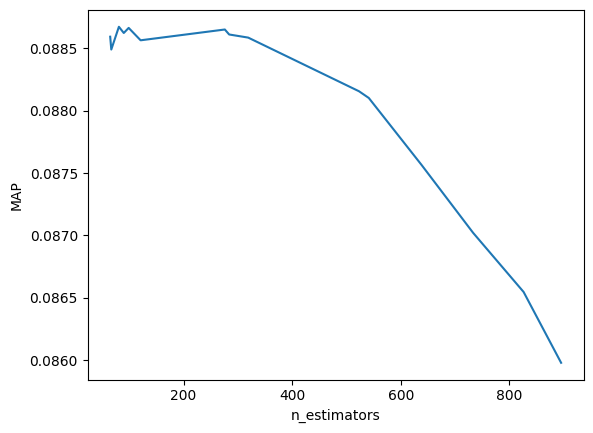

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["n_estimators"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('n_estimators')
pyplot.show()

In [ ]:
best_n_estimators_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_n_estimators_value

n_estimators          81
MAP             0.088672
Name: 7, dtype: object

reg_alpha

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["n_estimators", "reg_alpha", "MAP"])
hyperparameter_search_rnd["reg_alpha"] = rnd_reg_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="reg_alpha")
hyperparameter_search_rnd["n_estimators"] = best_n_estimators_value["n_estimators"]

alpha = 0.88
beta = 0.685907

init_rec_cutoff = best_Init_rec_cutoff_value['Init_rec_cutoff']
default_max_depth = 5
default_learning_rate = 0.1
default_reg_lambda = 0.1

for index in hyperparameter_search_rnd.index:
  xgboost_model_hyperparams = {'n_estimators':best_n_estimators_value["n_estimators"],
                             'learning_rate':default_learning_rate,'reg_alpha':hyperparameter_search_rnd.loc[index,"reg_alpha"],
                               'reg_lambda':default_reg_lambda,'max_depth':default_max_depth,'max_leaves':0,
                             'grow_policy':"depthwise",'objective':"pairwise",'booster':"gbtree",
                             'use_user_profile':False,'random_seed':None
                             }
  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the recommender models trained on RecommenderFold of the current fold to prepare for XGboost training
    initial_S_slim_elastic = xgboostfold_models[k]["SLIM"]
    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_hybrid3models_similarity = beta * ((1 - alpha) * initial_S_ibcf  + alpha * initial_S_slim_elastic) + (1 - beta) * initial_S_easer


    # Models for features generation
    initial_hybrid3models_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_hybrid3models_object.fit(initial_hybrid3models_similarity)
    initial_hybrid3models = Predictor(URM=data_xgboostfolds[k]['train_recommender'], model = initial_hybrid3models_object)

    initial_S_rp3beta = xgboostfold_models[k]["rp3beta"]
    initial_rp3beta_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_rp3beta_object.fit(initial_S_rp3beta)

    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_easer_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_easer_object.fit(initial_S_easer)

    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_ibcf_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_ibcf_object.fit(initial_S_ibcf)

    init_pureSVDRecommender = PureSVDRecommender(data_xgboostfolds[k]['train_recommender'])
    init_pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    init_itemFactors = init_pureSVDRecommender.ITEM_factors
    init_userFactors = init_pureSVDRecommender.USER_factors

    init_other_algorithms = {
    "rp3beta": initial_rp3beta_object,
    "EASER": initial_easer_object,
    "IBCF":initial_ibcf_object,
    'PureSVD_itemFactors':init_itemFactors,
    'PureSVD_userFactors':init_userFactors}

    # Get XGboost trained
    xgboost_trained = train_xgboost(data_xgboostfolds[k]['train_recommender'],data_xgboostfolds[k]['train_xgboost'],
                                  initial_hybrid3models,initial_recommendations_cutoff = init_rec_cutoff, other_algorithms = init_other_algorithms,
                                  xgboost_hyperparams = xgboost_model_hyperparams)


    # Define the recommender models trained on the whole current fold to prepare for the evaluation
    S_slim_elastic = fold_models[k]["SLIM"]
    S_ibcf = fold_models[k]["IBCF"]
    S_easer = fold_models[k]["EASER"]
    hybrid3models_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

    hybrid3models_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    hybrid3models_object.fit(hybrid3models_similarity)
    hybrid3models = Predictor(URM=fold['train'], model = hybrid3models_object)

    # Models for features generation
    S_rp3beta = fold_models[k]["rp3beta"]
    rp3beta_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    rp3beta_object.fit(S_rp3beta)

    S_easer = fold_models[k]["EASER"]
    easer_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    easer_object.fit(S_easer)

    S_ibcf = fold_models[k]["IBCF"]
    ibcf_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    ibcf_object.fit(S_ibcf)

    pureSVDRecommender = PureSVDRecommender(fold['train'])
    pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    itemFactors = pureSVDRecommender.ITEM_factors
    userFactors = pureSVDRecommender.USER_factors

    other_algorithms = {
    "rp3beta": rp3beta_object,
    "EASER": easer_object,
    "IBCF":ibcf_object,
    'PureSVD_itemFactors':itemFactors,
    'PureSVD_userFactors':userFactors}

    features_df = prepare_training_df(fold['train'],fold['train'],hybrid3models,init_rec_cutoff,other_algorithms)
    features_df = features_df.drop(columns=["Label"])


    map, mp,mr = evaluate_xgboost(fold['val'],features_df,xgboost_trained)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for reg_alpha:{hyperparameter_search_rnd.loc[index,"reg_alpha"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:53<00:00, 235.14it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 264.69it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0889657825
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 260.95it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 271.08it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0892067261
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.82it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 273.38it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0865448262
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 268.53it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 268.77it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0909462607
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 262.38it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 272.97it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0891334034
The crossvalidation MAP for n_estimators:4 is 0.08895939979027237
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 256.53it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 263.70it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0767484561
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 248.73it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 272.63it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0786949078
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:51<00:00, 244.02it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.91it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0759837422
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 251.12it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 270.69it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0787014841
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.44it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 263.33it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0796008778
The crossvalidation MAP for n_estimators:10 is 0.07794589359515228
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 270.31it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 255.99it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0726470759
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 267.56it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:53<00:00, 238.28it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0730277985
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 277.98it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 258.52it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0733446888
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 270.43it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.47it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0755702921
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 277.40it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 255.04it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0774879036
The crossvalidation MAP for n_estimators:11 is 0.07441555177500078
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.38it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.51it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0638315976
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 260.46it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 265.14it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0659238438
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.19it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 264.75it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0648375824
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 271.78it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.18it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0668468404
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 269.36it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 250.19it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0671173057
The crossvalidation MAP for n_estimators:17 is 0.065711433992285


   n_estimators  max_depth       MAP
3            81          4  0.088959
1            81         10  0.077946
2            81         11  0.074416
0            81         17  0.065711


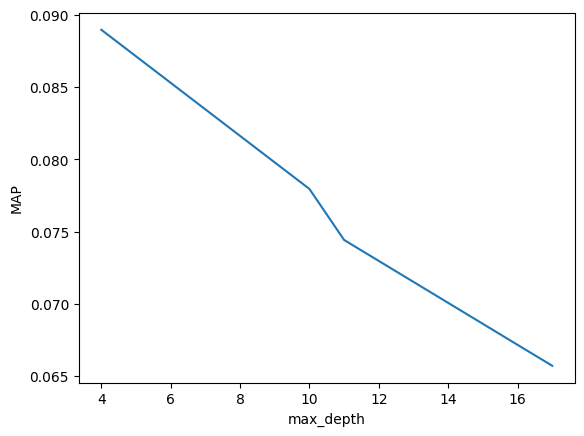

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["reg_alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('reg_alpha')
pyplot.show()

In [ ]:
best_reg_alpha = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_reg_alpha

n_estimators          81
max_depth              4
MAP             0.088959
Name: 3, dtype: object

n_estimators          81
max_depth              4
MAP             0.088959
Name: 3, dtype: object

learning rate to consider

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["n_estimators", "reg_alpha","learning_rate", "MAP"])
hyperparameter_search_rnd["learning_rate"] = rnd_learning_rate
hyperparameter_search_rnd["n_estimators"] = best_n_estimators_value["n_estimators"]
hyperparameter_search_rnd["reg_alpha"] = best_reg_alpha["reg_alpha"]
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="learning_rate")

alpha = 0.88
beta = 0.685907

init_rec_cutoff = best_Init_rec_cutoff_value['Init_rec_cutoff']
default_max_depth = 5
default_reg_lambda = 0.1

for index in hyperparameter_search_rnd.index:
  xgboost_model_hyperparams = {'n_estimators':best_n_estimators_value["n_estimators"],
                             'learning_rate':hyperparameter_search_rnd.loc[index,"learning_rate"],'reg_alpha':best_reg_alpha["reg_alpha"],
                              'reg_lambda':default_reg_lambda,'max_depth':default_max_depth,'max_leaves':0,
                             'grow_policy':"depthwise",'objective':"pairwise",'booster':"gbtree",
                             'use_user_profile':False,'random_seed':None
                             }
  folds_map = []
  for k,fold in enumerate(data_folds):
    print(f'Fold {k} evaluations started')
    # Define the recommender models trained on RecommenderFold of the current fold to prepare for XGboost training
    initial_S_slim_elastic = xgboostfold_models[k]["SLIM"]
    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_hybrid3models_similarity = beta * ((1 - alpha) * initial_S_ibcf  + alpha * initial_S_slim_elastic) + (1 - beta) * initial_S_easer


    # Models for features generation
    initial_hybrid3models_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_hybrid3models_object.fit(initial_hybrid3models_similarity)
    initial_hybrid3models = Predictor(URM=data_xgboostfolds[k]['train_recommender'], model = initial_hybrid3models_object)

    initial_S_rp3beta = xgboostfold_models[k]["rp3beta"]
    initial_rp3beta_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_rp3beta_object.fit(initial_S_rp3beta)

    initial_S_easer = xgboostfold_models[k]["EASER"]
    initial_easer_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_easer_object.fit(initial_S_easer)

    initial_S_ibcf = xgboostfold_models[k]["IBCF"]
    initial_ibcf_object = ItemKNNCustomSimilarityRecommender(data_xgboostfolds[k]['train_recommender'])
    initial_ibcf_object.fit(initial_S_ibcf)

    init_pureSVDRecommender = PureSVDRecommender(data_xgboostfolds[k]['train_recommender'])
    init_pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    init_itemFactors = init_pureSVDRecommender.ITEM_factors
    init_userFactors = init_pureSVDRecommender.USER_factors

    init_other_algorithms = {
    "rp3beta": initial_rp3beta_object,
    "EASER": initial_easer_object,
    "IBCF":initial_ibcf_object,
    'PureSVD_itemFactors':init_itemFactors,
    'PureSVD_userFactors':init_userFactors}

    # Get XGboost trained
    xgboost_trained = train_xgboost(data_xgboostfolds[k]['train_recommender'],data_xgboostfolds[k]['train_xgboost'],
                                  initial_hybrid3models,initial_recommendations_cutoff = init_rec_cutoff, other_algorithms = init_other_algorithms,
                                  xgboost_hyperparams = xgboost_model_hyperparams)


    # Define the recommender models trained on the whole current fold to prepare for the evaluation
    S_slim_elastic = fold_models[k]["SLIM"]
    S_ibcf = fold_models[k]["IBCF"]
    S_easer = fold_models[k]["EASER"]
    hybrid3models_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

    hybrid3models_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    hybrid3models_object.fit(hybrid3models_similarity)
    hybrid3models = Predictor(URM=fold['train'], model = hybrid3models_object)

    # Models for features generation
    S_rp3beta = fold_models[k]["rp3beta"]
    rp3beta_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    rp3beta_object.fit(S_rp3beta)

    S_easer = fold_models[k]["EASER"]
    easer_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    easer_object.fit(S_easer)

    S_ibcf = fold_models[k]["IBCF"]
    ibcf_object = ItemKNNCustomSimilarityRecommender(fold['train'])
    ibcf_object.fit(S_ibcf)

    pureSVDRecommender = PureSVDRecommender(fold['train'])
    pureSVDRecommender.fit(num_factors=10,random_seed  = 42)
    itemFactors = pureSVDRecommender.ITEM_factors
    userFactors = pureSVDRecommender.USER_factors

    other_algorithms = {
    "rp3beta": rp3beta_object,
    "EASER": easer_object,
    "IBCF":ibcf_object,
    'PureSVD_itemFactors':itemFactors,
    'PureSVD_userFactors':userFactors}

    features_df = prepare_training_df(fold['train'],fold['train'],hybrid3models,init_rec_cutoff,other_algorithms)
    features_df = features_df.drop(columns=["Label"])


    map, mp,mr = evaluate_xgboost(fold['val'],features_df,xgboost_trained)
    folds_map.append(map)


  cv_map = np.array(folds_map).sum()/len(data_folds)
  print(f'The crossvalidation MAP for learning_rate:{hyperparameter_search_rnd.loc[index,"learning_rate"]} is {cv_map}')
  hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:51<00:00, 247.23it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 267.35it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0849263820
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:52<00:00, 240.65it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 258.60it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0862102403
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 248.17it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 269.14it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0834449584
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:52<00:00, 238.83it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 257.77it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0874085603
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 254.61it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 256.89it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0869964215
The crossvalidation MAP for learning_rate:0.00090714 is 0.08579731248545568
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 259.93it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 263.62it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0856137420
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 260.84it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 267.35it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0864556434
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 250.14it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 262.55it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0843993037
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 258.48it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 271.87it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0886530794
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 256.87it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 277.47it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0886109979
The crossvalidation MAP for learning_rate:0.00219428 is 0.08674655326425809
Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 424 ( 3.4%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 334 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:50<00:00, 252.46it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:46<00:00, 274.73it/s]


Recommender results are: Precision = 232.4569536424, Recall = 3727.6596412253, MAP = 0.0883855759
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 464 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 345 ( 1.6%) items with no interactions.


100%|██████████| 12638/12638 [00:52<00:00, 242.11it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 267.47it/s]


Recommender results are: Precision = 232.7284768212, Recall = 3731.9027630466, MAP = 0.0887172491
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:48<00:00, 260.72it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 274.99it/s]


Recommender results are: Precision = 230.7682119205, Recall = 3700.0388609476, MAP = 0.0867487121
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 497 ( 3.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 335 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 253.12it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 96 ( 0.4%) items with no interactions.


100%|██████████| 12638/12638 [00:47<00:00, 266.93it/s]


Recommender results are: Precision = 233.2119205298, Recall = 3780.7097934755, MAP = 0.0906138477
Fold 4 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 478 ( 3.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 337 ( 1.5%) items with no interactions.


100%|██████████| 12638/12638 [00:49<00:00, 255.47it/s]


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:45<00:00, 275.10it/s]


Recommender results are: Precision = 232.1192052980, Recall = 3736.8770752091, MAP = 0.0891758862
The crossvalidation MAP for learning_rate:0.03235245 is 0.08872825420793459


   n_estimators  max_depth  learning_rate       MAP
1            81          4       0.000907  0.085797
2            81          4       0.002194  0.086747
0            81          4       0.032352  0.088728


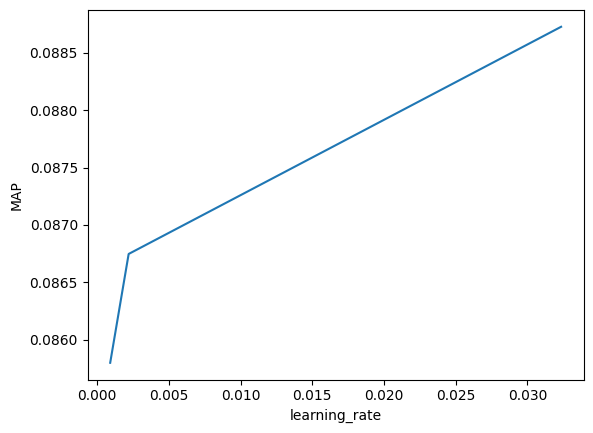

In [ ]:
print(hyperparameter_search_rnd)
pyplot.plot(hyperparameter_search_rnd["learning_rate"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('learning_rate')
pyplot.show()

In [ ]:
best_values = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_values

n_estimators           81
max_depth               4
learning_rate    0.032352
MAP              0.088728
Name: 0, dtype: object

# Predict for the test data

**Now let's read the data we want to predict for and see if there're overlaps with UserIDs in train data**

In [ ]:
urm_pred_path = '/content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_pred_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])
print('Unique user id to predict:', urm_pred_df['UserID'].nunique())

Unique user id to predict: 10882


### Generate features and initial predictions

In [ ]:
# Define the recommender models trained on RecommenderFold of the current fold to prepare for XGboost training
# NON-Normalised SIMILARITIES

init_rec_cutoff = 151

alpha = 0.88
beta = 0.685907

xgboost_model_hyperparams = {'n_estimators':81,
                             'learning_rate':0.1,'reg_alpha':1e-1,'reg_lambda':1e-1,'max_depth':4,'max_leaves':0,
                             'grow_policy':"depthwise",'objective':"pairwise",'booster':"gbtree",
                             'use_user_profile':False,'random_seed':None
                             }


initial_S_slim_elastic = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold4_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')
initial_S_ibcf = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold4_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')
initial_S_easer = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold4_noemptyprofiles_EASER_kaggleMAP0.12504.npz')
initial_hybrid3models_similarity = beta * ((1 - alpha) * initial_S_ibcf  + alpha * initial_S_slim_elastic) + (1 - beta) * initial_S_easer

initial_hybrid3models_object = ItemKNNCustomSimilarityRecommender(data_folds[4]['train'])
initial_hybrid3models_object.fit(initial_hybrid3models_similarity)
initial_hybrid3models = Predictor(URM=data_folds[4]['train'], model = initial_hybrid3models_object)


# Models for features generation
initial_S_rp3beta = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold4_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')
initial_rp3beta_object = ItemKNNCustomSimilarityRecommender(data_folds[4]['train'])
initial_rp3beta_object.fit(initial_S_rp3beta)

initial_S_easer = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold4_noemptyprofiles_EASER_kaggleMAP0.12504.npz')
initial_easer_object = ItemKNNCustomSimilarityRecommender(data_folds[4]['train'])
initial_easer_object.fit(initial_S_easer)

initial_S_ibcf = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold4_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')
initial_ibcf_object = ItemKNNCustomSimilarityRecommender(data_folds[4]['train'])
initial_ibcf_object.fit(initial_S_ibcf)

init_other_algorithms = {
    "rp3beta": initial_rp3beta_object,
    "EASER": initial_easer_object,
    "IBCF":initial_ibcf_object}

# Get XGboost trained
xgboost_trained = train_xgboost(data_folds[4]['train'],data_folds[4]['val'],
                                  initial_hybrid3models,initial_recommendations_cutoff = init_rec_cutoff, other_algorithms = init_other_algorithms,
                                  xgboost_hyperparams = xgboost_model_hyperparams)


# Define the recommender models trained on the whole current fold to prepare for the evaluation
S_slim_elastic = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')
S_ibcf = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')
S_easer = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_EASER_kaggleMAP0.12504.npz')
hybrid_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

hybrid_recommender_object = ItemKNNCustomSimilarityRecommender(urm_all)
hybrid_recommender_object.fit(hybrid_similarity)
hybrid_3models = Predictor(URM=urm_all, model = hybrid_recommender_object)

# Models for features generation
S_rp3beta = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')
rp3beta_object = ItemKNNCustomSimilarityRecommender(urm_all)
rp3beta_object.fit(S_rp3beta)

S_easer = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_EASER_kaggleMAP0.12504.npz')
easer_object = ItemKNNCustomSimilarityRecommender(urm_all)
easer_object.fit(S_easer)

S_ibcf = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')
ibcf_object = ItemKNNCustomSimilarityRecommender(urm_all)
ibcf_object.fit(S_ibcf)

other_algorithms = {
    "rp3beta": rp3beta_object,
    "EASER": easer_object,
    "IBCF":ibcf_object}

features_df = prepare_training_df(urm_all,urm_all,hybrid_3models,init_rec_cutoff,other_algorithms)
features_df = features_df.drop(columns=["Label"])


ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 239 ( 1.9%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 124 ( 0.6%) items with no interactions.


100%|██████████| 12638/12638 [00:54<00:00, 231.05it/s]


### Do the predictions, but bear in mind that before feeding the user_id to the model you need to translate it to the model user indices space. Also, you have to translate the recommended item IDs into the original IDs space form the model item IDs space

In [ ]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  if userid in user_original_ID_to_index.keys():
    # Map user ID to the index of model user space
    usr_idx = user_original_ID_to_index[userid]

    # Extract the predictions and features for the user
    X_to_predict = features_df[features_df["UserID"] == usr_idx]
    # Do the reranking prediction
    item_reranking_scores = xgboost_trained.predict(X_to_predict)
    if len(item_reranking_scores) == 0:
      print(f'Lenght of reranking for user {usr_idx} is 0')
    # Rerank the items according to the reranking scores
    initial_recommendations = X_to_predict.ItemID.to_list()
    reranked_recommendations = np.array(initial_recommendations)[np.argsort(item_reranking_scores)[::-1]]

    # Map item indices from model item space to original item ID
    recomendatoins = [item_index_to_original_ID[idx] for idx in reranked_recommendations][:10] # Extract only first top-10 recommendations
  else:
    # If the user isn't present in the given data, recommend TopPop items
    recomendatoins = [2, 4, 1, 7, 3, 6, 8, 9, 15, 20]

  recomendatoins = " ".join(str(item) for item in recomendatoins)
  pred_df.loc[len(pred_df)] = [userid,recomendatoins]

In [ ]:
pred_df

,user_id,item_list
0,1,101 36 123 506 515 403 977 694 8 52
1,2,1095 47 12 50 1522 102 949 28 656 3176
2,3,59 536 648 259 584 956 857 4252 2172 1281
3,4,249 28 50 5 136 171 7 139 146 1
4,5,1570 77 170 131 1511 5138 95 135 1264 116
...,...,...
10877,13020,6450 6452 6198 6749 7395 7394 105 155 627 4323
10878,13021,6720 6179 6451 579 7027 6426 265 133 139 6749
10879,13022,1668 1411 809 1446 1674 1013 1258 776 4688 1561
10880,13023,329 1124 1107 706 1534 1290 1532 96 208 32


In [ ]:
pred_df.to_csv('/content/pred_best3modelsHybrid_kaggle0.13731_XGboost_reranked.v5_Max.csv',index=False)

**Define the model to generate recommendations**

In [ ]:
# Define our best submission model i.e. hybrid of NON-NORMALISED SIMILARITIES 0.685907*(0.88*SLIM elasticnet + 0.12*IBCF)+(1 - 0.685907)*EASER

alpha = 0.88
beta = 0.685907

S_slim_elastic = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')
S_ibcf = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')
S_easer = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_EASER_kaggleMAP0.12504.npz')
hybrid_similarity = beta * ((1 - alpha) * S_ibcf_f0  + alpha * S_slim_elastic_f0) + (1 - beta) * S_easer_f0

hybrid_recommender_object = ItemKNNCustomSimilarityRecommender(urm_all)
hybrid_recommender_object.fit(hybrid_similarity)
hybrid_3models = Predictor(URM=data_fold0['train'], model = hybrid_recommender_object)



**Build the dataframe with the predictions**

In [ ]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = urm_all.shape

feature_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
feature_dataframe.index.name='UserID'

In [ ]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = hybrid_3models.recommend(user_id, at = cutoff)
    feature_dataframe.loc[user_id, "ItemID"] = recommendations



100%|██████████| 12638/12638 [00:27<00:00, 461.34it/s]


**Transform the dataframe so that we have one recommendation per row**

In [ ]:
feature_dataframe = feature_dataframe.explode("ItemID")
feature_dataframe['ItemID'] = pd.to_numeric(feature_dataframe['ItemID'])
feature_dataframe

,ItemID
UserID,
0,674
0,587
0,4
0,1449
0,1585
...,...
12637,10906
12637,327
12637,10898


**Now let's add features as the prediction of other algorithms**

In [ ]:
S_rp3beta = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')
rp3beta_recommender_object = ItemKNNCustomSimilarityRecommender(urm_all)
rp3beta_recommender_object.fit(S_rp3beta)

S_ibcf = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')
ibcf_recommender_object = ItemKNNCustomSimilarityRecommender(urm_all)
ibcf_recommender_object.fit(S_ibcf)

S_easer = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /Whole_data_trained_models/ItItSimilarity_trained_whole_data_noemptyprofiles_EASER_kaggleMAP0.12504.npz')
easer_recommender_object = ItemKNNCustomSimilarityRecommender(urm_all)
easer_recommender_object.fit(S_easer)


other_algorithms = {
    "rp3beta": rp3beta_recommender_object,
    "EASER": easer_recommender_object,
    "IBCF":ibcf_recommender_object
}


In [ ]:
for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = feature_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        feature_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

feature_dataframe = feature_dataframe.reset_index()
feature_dataframe = feature_dataframe.rename(columns = {"index": "UserID"})
feature_dataframe

100%|██████████| 12638/12638 [00:43<00:00, 291.20it/s]


,UserID,ItemID,rp3beta,EASER,IBCF
0,0,674,3.134753,0.580700,1.430089
1,0,587,2.938181,0.525053,1.325987
2,0,4,2.296468,0.411727,0.969061
3,0,1449,1.813740,0.285123,1.163741
4,0,1585,1.646992,0.258653,1.225756
...,...,...,...,...,...
379135,12637,10906,4.128965,0.224337,1.724024
379136,12637,327,2.588722,0.253466,1.372146
379137,12637,10898,2.446541,0.205400,1.613066
379138,12637,17581,4.585013,0.464015,1.652618


**The popularity of the item, the user activity and etc. features**

In [ ]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_all).indptr)

feature_dataframe['item_popularity'] = item_popularity[feature_dataframe["ItemID"].values.astype(int)]
feature_dataframe

,UserID,ItemID,rp3beta,EASER,IBCF,item_popularity
0,0,674,3.134753,0.580700,1.430089,426
1,0,587,2.938181,0.525053,1.325987,713
2,0,4,2.296468,0.411727,0.969061,255
3,0,1449,1.813740,0.285123,1.163741,119
4,0,1585,1.646992,0.258653,1.225756,97
...,...,...,...,...,...,...
379135,12637,10906,4.128965,0.224337,1.724024,17
379136,12637,327,2.588722,0.253466,1.372146,208
379137,12637,10898,2.446541,0.205400,1.613066,39
379138,12637,17581,4.585013,0.464015,1.652618,18


**The profile length**

In [ ]:
user_popularity = np.ediff1d(sps.csr_matrix(urm_all).indptr)

feature_dataframe['user_profile_len'] = user_popularity[feature_dataframe["UserID"].values.astype(int)]
feature_dataframe

,UserID,ItemID,rp3beta,EASER,IBCF,item_popularity,user_profile_len
0,0,674,3.134753,0.580700,1.430089,426,44
1,0,587,2.938181,0.525053,1.325987,713,44
2,0,4,2.296468,0.411727,0.969061,255,44
3,0,1449,1.813740,0.285123,1.163741,119,44
4,0,1585,1.646992,0.258653,1.225756,97,44
...,...,...,...,...,...,...,...
379135,12637,10906,4.128965,0.224337,1.724024,17,71
379136,12637,327,2.588722,0.253466,1.372146,208,71
379137,12637,10898,2.446541,0.205400,1.613066,39,71
379138,12637,17581,4.585013,0.464015,1.652618,18,71


In [ ]:
feature_dataframe = feature_dataframe.sort_values("UserID").reset_index()
feature_dataframe.drop(columns = ['index'], inplace=True)
feature_dataframe

,UserID,ItemID,rp3beta,EASER,IBCF,item_popularity,user_profile_len
0,0,674,3.134753,0.580700,1.430089,426,44
1,0,2023,1.360364,0.174129,0.963579,66,44
2,0,4802,0.418168,0.115895,0.345417,37,44
3,0,285,1.549731,0.216215,0.450033,1243,44
4,0,99,1.054120,0.111644,0.618664,219,44
...,...,...,...,...,...,...,...
379135,12637,10902,4.442462,0.345211,2.574058,31,71
379136,12637,16585,5.006367,0.539446,4.154074,17,71
379137,12637,17581,4.585013,0.464015,1.652618,18,71
379138,12637,17580,3.714199,0.238553,1.929736,17,71


**To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidate items for each user all groups have the same length.**

In [ ]:
groups = feature_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

### Do the predictions, but bear in mind that before feeding the user_id to the model you need to translate it to the model user indices space. Also, you have to translate the recommended item IDs into the original IDs space form the model item IDs space

In [ ]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  if userid in user_original_ID_to_index.keys():
    # Map user ID to the index of model user space
    usr_idx = user_original_ID_to_index[userid]

    # Extract the predictions and features for the user
    X_to_predict = feature_dataframe[feature_dataframe["UserID"] == usr_idx]
    # Do the reranking prediction
    item_reranking_scores = XGB_model.predict(X_to_predict)
    if len(item_reranking_scores) == 0:
      print(f'Lenght of reranking for user {usr_idx} is 0')
    # Rerank the items according to the reranking scores
    initial_recommendations = X_to_predict.ItemID.to_list()
    reranked_recommendations = np.array(initial_recommendations)[np.argsort(item_reranking_scores)[::-1]]

    # Map item indices from model item space to original item ID
    recomendatoins = [item_index_to_original_ID[idx] for idx in reranked_recommendations][:10] # Extract only first top-10 recommendations
  else:
    # If the user isn't present in the given data, recommend TopPop items
    recomendatoins = [2, 4, 1, 7, 3, 6, 8, 9, 15, 20]

  recomendatoins = " ".join(str(item) for item in recomendatoins)
  pred_df.loc[len(pred_df)] = [userid,recomendatoins]

In [ ]:
pred_df

,user_id,item_list
0,1,36 101 161 123 1935 403 515 699 506 52
1,2,1095 1522 12 47 656 949 50 3176 28 196
2,3,59 536 4252 648 857 956 584 259 4 2172
3,4,28 11 27 249 50 1 1719 5 136 171
4,5,1570 170 1511 77 131 8 5138 7033 9582 9039
...,...,...
10877,13020,105 6450 6198 6452 627 7395 6749 7394 1191 155
10878,13021,16115 133 269 304 6427 6722 6724 859 17945 3071
10879,13022,809 1668 1411 1446 1767 1674 1013 4688 16075 1...
10880,13023,329 299 252 119 249 1107 1124 1290 706 32


In [ ]:
pred_df.to_csv('/content/pred_best3modelsHybrid_kaggle0.13731_XGboost_reranked_Max.csv',index=False)